In [235]:
import os
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

print("TensorFlow:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

DATA_ROOT = '/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset'
IMAGES_DIR = os.path.join(DATA_ROOT, 'original_images')
MASKS_DIR = os.path.join(DATA_ROOT, 'label_images_semantic')

IMG_SIZE = 256
BATCH_SIZE = 4
EPOCHS = 25
LEARNING_RATE = 1e-4

MODEL_PATH = '/kaggle/working/drone_fcn_model.h5'

print("Images:", len(os.listdir(IMAGES_DIR)), "Masks:", len(os.listdir(MASKS_DIR)))


TensorFlow: 2.18.0
GPU available: []
Images: 400 Masks: 400


In [236]:
def read_pair(img_path):
    filename = tf.strings.split(img_path, os.sep)[-1]
    mask_path = tf.strings.join([MASKS_DIR, "/", filename])

    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE), method='nearest')
    mask = tf.cast(mask, tf.int32)

    return img, mask

image_paths = tf.io.gfile.glob(f"{IMAGES_DIR}/*.png")
image_paths = tf.constant(image_paths, dtype=tf.string)

dataset = tf.data.Dataset.from_tensor_slices(image_paths)
dataset = dataset.map(read_pair, num_parallel_calls=tf.data.AUTOTUNE)

val_size = int(0.2 * len(image_paths))
train_ds = dataset.skip(val_size).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = dataset.take(val_size).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for img, mask in train_ds.take(1):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(img[0])
    plt.title("Sample Image")
    plt.subplot(1,2,2)
    plt.imshow(mask[0].numpy().squeeze(), cmap='nipy_spectral')
    plt.title("Sample Mask")
    plt.show()


In [237]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Concatenate

NUM_CLASSES = 24  # Semantic drone dataset has 23–24 classes


def build_fcn_vgg(input_shape=(256, 256, 3)):
    inp = Input(input_shape)
    vgg = VGG16(include_top=False, weights=None, input_tensor=inp)


    c1 = vgg.get_layer('block3_pool').output
    c2 = vgg.get_layer('block4_pool').output
    c3 = vgg.get_layer('block5_pool').output

    u1 = UpSampling2D((2, 2))(c3)
    u1 = Concatenate()([u1, c2])
    u1 = Conv2D(256, (3, 3), activation='relu', padding='same')(u1)

    u2 = UpSampling2D((2, 2))(u1)
    u2 = Concatenate()([u2, c1])
    u2 = Conv2D(128, (3, 3), activation='relu', padding='same')(u2)

    u3 = UpSampling2D((2, 2))(u2)
    u3 = Conv2D(64, (3, 3), activation='relu', padding='same')(u3)

    out = Conv2D(NUM_CLASSES, (1, 1), activation='softmax')(u3)

    model = Model(inputs=inp, outputs=out)
    return model

model = build_fcn_vgg()
model.summary()


Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_26      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 256, 256,  │      1,792 │ input_layer_26[0… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 256, 256,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 128, 128,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 128, 128,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 128, 128,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 64, 64,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 64, 64,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 64, 64,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 64, 64,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 32, 32,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 32, 32,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 32, 32,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 32, 32,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 16, 16,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 16, 16,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 16, 16,    │  2,359,808 │ block5_conv1[0][

 Total params: 17,739,544 (67.67 MB)

 Trainable params: 17,739,544 (67.67 MB)

 Non-trainable params: 0 (0.00 B)

In [238]:
from tensorflow.keras.layers import Conv2DTranspose, Conv2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16

def build_fcn_vgg(input_shape=(256, 256, 3), num_classes=24):
    inp = Input(input_shape)
    vgg = VGG16(include_top=False, weights=None, input_tensor=inp)

    c1 = vgg.get_layer('block3_pool').output
    c2 = vgg.get_layer('block4_pool').output
    c3 = vgg.get_layer('block5_pool').output

    # Decoder
    x = Conv2DTranspose(512, (3, 3), strides=2, padding='same', activation='relu')(c3)
    x = Conv2DTranspose(256, (3, 3), strides=2, padding='same', activation='relu')(x)
    x = Conv2DTranspose(128, (3, 3), strides=2, padding='same', activation='relu')(x)
    x = Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='relu')(x)
    
    # Final layer to upsample to (256x256)
    x = Conv2DTranspose(num_classes, (4, 4), strides=(4, 4), padding='same', activation='softmax')(x)

    model = Model(inputs=inp, outputs=x)
    return model


In [239]:
COLORMAP = np.array([
    [128, 64,128], [244, 35,232], [70,70,70], [102,102,156],
    [190,153,153], [153,153,153], [250,170,30], [220,220,0],
    [107,142,35], [152,251,152], [70,130,180], [220,20,60],
    [255,0,0], [0,0,142], [0,0,70], [0,60,100],
    [0,80,100], [0,0,230], [119,11,32], [0,255,255],
    [255,255,0], [255,0,255], [128,128,0], [0,255,0]
], dtype=np.uint8)

def colorize_mask(mask):
    mask = np.squeeze(mask)
    return COLORMAP[mask % len(COLORMAP)]

def show_prediction(model, dataset, num=1):
    for img, mask in dataset.take(num):
        pred = model.predict(img)
        pred = tf.argmax(pred, axis=-1)
        pred = pred[0].numpy()

        plt.figure(figsize=(15,5))
        plt.subplot(1,3,1)
        plt.imshow(img[0])
        plt.title("Original Image")

        plt.subplot(1,3,2)
        plt.imshow(colorize_mask(mask[0].numpy()))
        plt.title("True Mask")

        plt.subplot(1,3,3)
        plt.imshow(colorize_mask(pred))
        plt.title("Predicted Segmentation")
        plt.show()

show_prediction(model, val_ds, num=2)


In [240]:
model.save("/kaggle/working/drone_fcn_model_fixed.keras")
print("✅ Model saved successfully!")


✅ Model saved successfully!


In [241]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from PIL import Image

def visualize_prediction(model, img_path, img_size=256):
    # Load and preprocess image
    img = Image.open(img_path).resize((img_size, img_size))
    input_arr = np.array(img) / 255.0
    input_arr = np.expand_dims(input_arr, axis=0)

    # Predict
    pred_mask = model.predict(input_arr)[0]

    # If it's softmax output (multi-class)
    if pred_mask.shape[-1] > 1:
        pred_mask = tf.argmax(pred_mask, axis=-1)
    else:
        pred_mask = (pred_mask > 0.5).astype(np.uint8)

    pred_mask = np.squeeze(pred_mask)

    # ✅ Resize mask back to 256×256 for clarity
    pred_mask_resized = tf.image.resize(
        pred_mask[..., np.newaxis],
        (img_size, img_size),
        method='nearest'
    ).numpy().squeeze()

    # ✅ Use a clear color map
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original Drone Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(pred_mask_resized, cmap='nipy_spectral')
    plt.title("Predicted Segmentation (Clear View)")
    plt.axis('off')

    plt.show()


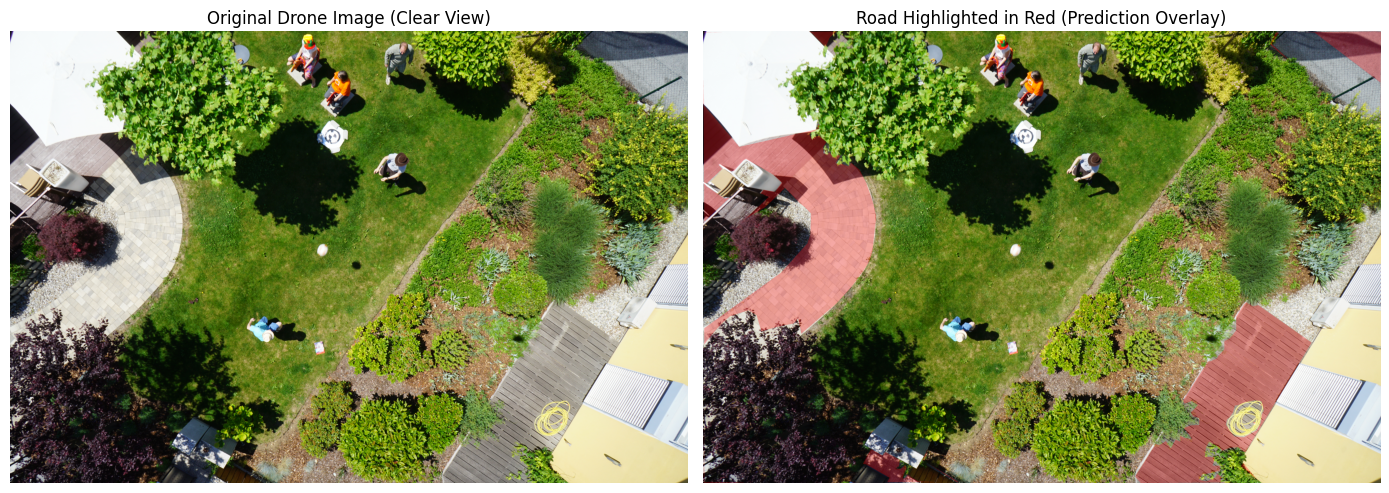

In [242]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Paths (make sure these exist)
original_image_path = "/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/026.jpg"
pred_mask_path = "/kaggle/input/semantic-drone-dataset/RGB_color_image_masks/RGB_color_image_masks/026.png"

# Load and convert to arrays
original_image = np.array(Image.open(original_image_path).convert("RGB"))
pred_mask = np.array(Image.open(pred_mask_path).convert("RGB"))

# Identify road color (you can tweak this if needed)
# [128, 64, 128] is standard for 'road'
road_mask = np.all(pred_mask == [128, 64, 128], axis=-1)

# Normalize original image
original_image = original_image / 255.0

# Create red overlay
overlay = original_image.copy()
overlay[road_mask] = [1, 0, 0]  # red for road

# Blend for transparency (change weights if you want stronger red)
blended = (0.7 * original_image + 0.3 * overlay)

# Show side-by-side
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

axes[0].imshow(original_image)
axes[0].set_title("Original Drone Image (Clear View)")
axes[0].axis("off")

axes[1].imshow(blended)
axes[1].set_title("Road Highlighted in Red (Prediction Overlay)")
axes[1].axis("off")

plt.tight_layout()
plt.show()
